In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import json
import time
import math

25.96
Accuracy-iteration: 89.02% Learning rate --> 0.0099
8.72
Accuracy-iteration: 87.80% Learning rate --> 0.009801
8.3
Accuracy-iteration: 84.15% Learning rate --> 0.00970299
9.35
Accuracy-iteration: 87.80% Learning rate --> 0.0096059601
8.08
Accuracy-iteration: 84.15% Learning rate --> 0.009509900499
8.92
Accuracy-iteration: 81.71% Learning rate --> 0.00941480149401
8.38
Accuracy-iteration: 81.71% Learning rate --> 0.0093206534790699
8.16
Accuracy-iteration: 86.59% Learning rate --> 0.0092274469442792
9.77
Accuracy-iteration: 84.15% Learning rate --> 0.009135172474836408
9.99
Accuracy-iteration: 85.37% Learning rate --> 0.009043820750088045
Average training time for network running 300 iterations with batch size 2 --->9.601448488235473s


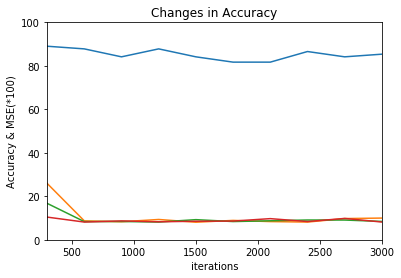

In [4]:
class Network_layer:
    
    def __init__(self, number_input, number_neurons, use_standard_activation):
        #self.size = size
        self.weights = np.random.rand(number_input,number_neurons)
        self.bias = np.zeros(number_neurons)
        self.last_activation = None
        self.use_standard_activation = use_standard_activation
        self.error = None
        self.delta = None
        
    def activate(self, x):
        r = np.dot(x, self.weights) + self.bias
        if self.use_standard_activation:
            self.last_activation = self.activation(r)
        else: 
            self.last_activation = self.tanh(r)
            
        return self.last_activation
    
    def activation(self, x):
        #relu
        x[x<0] = 0
        return x
                
    def tanh(self, x):
        #tanh
        return np.tanh(x)
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def activation_derivative(self, x):
        if self.use_standard_activation:
            x[x>0] = 1
            x[x<0] = 0
            return x
        return 1.0 - np.tanh(x)**2
        '''
        if self.use_standard_activation:
            return 1.0 - np.tanh(x)**2
        return x * (1 - x)
        '''
    

class Neaural_net:
    layers = []
    
    def __init__(self):
        self.layers = []
    
    def add_layer(self, layer):
        self.layers.append(layer)
    
    def feed_forward(self, X):
        for layer in self.layers:
            X = layer.activate(X)
        return X

    def softmax(self,X):
        exps = np.exp(X)
        return exps / np.sum(exps)
    
    def cross_entropy(self, X,y):
        m = y.shape[0]
        p = self.softmax(X)
        
        likelihood = -np.log(p[range(m), y.argmax(axis=1)])
        loss = np.sum(likelihood) / m
        return loss
        
    def logloss(self, true_label, predicted, eps=1e-15):
        p = np.clip(predicted, eps, 1 - eps)
        if true_label == 1:
            return -math.log(p)
        else:
            return -math.log(1 - p) 
        
    def mae(self, targets, predictions):
        differences = predictions - targets
        absolute_differences = np.absolute(differences)
        mean_absolute_differences = absolute_differences.mean()
        return mean_absolute_differences
        
    def mean_squared_error(self, actual, predicted):
        sum_square_error = 0.0
        for i in range(len(actual)):
            sum_square_error += (actual[i] - predicted[i])**2.0
        mean_square_error = sum_square_error / len(actual)

        return mean_square_error
        
    def backpropagation(self, X, y, learning_rate):
        output = self.feed_forward(X)
        #print(output)
        #for i in reversed(range(len(self.layers))):
            #print(self.layers[i].weights.shape)
        average_activation = None
        
        for i in reversed(range(len(self.layers))):
            layer = self.layers[i]
            all_deltas = []
            last_activations = []
            for j in range(len(output)):
                if layer == self.layers[-1]:
                    layer.error =  y[j] - output[j]
                    #layer.error = log_loss(y, output)
                    #layer.error = y[j]-self.mean_squared_error(y[j],output[j])
                    all_deltas.append(layer.error * layer.activation_derivative(output[j]))
                    last_activations.append(layer.activation_derivative(output[j]))
                else:
                    next_layer = self.layers[i + 1]
                    layer.error = np.dot(next_layer.weights, next_layer.delta)
                    all_deltas.append(layer.error * layer.activation_derivative(layer.last_activation[j]))
                    last_activations.append(layer.activation_derivative(layer.last_activation[j]))
                    #print('sdfg', layer.delta)
                    
            average_delta = sum(all_deltas)/float(len(output))
            average_activation = sum(last_activations)/float(len(output))
            layer.delta = average_delta
    
                

        # Update the weights
        for j in range(len(output)):
            for i in range(len(self.layers)):
                layer = self.layers[i]
                #print(layer.delta)
                input_to_use = np.atleast_2d(X[j] if i == 0 else self.layers[i - 1].last_activation[j])
                #print(self.layers[i - 1].last_activation[j])
                layer.weights += layer.delta * input_to_use.T * learning_rate
            
    
    
    def iterate_minibatches(self, inputs, targets, batchsize, shuffle=False):
        assert len(inputs) == len(targets)
        if shuffle:
            indices = np.random.permutation(len(inputs))
        for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
            if shuffle:
                excerpt = indices[start_idx:start_idx + batchsize]
            else:
                excerpt = slice(start_idx, start_idx + batchsize)
            yield inputs[excerpt], targets[excerpt] 

            
    def train(self, X, y, learning_rate, max_epochs, batchsize):
        mses = []

        for i in range(max_epochs):
            for x_batch,y_batch in self.iterate_minibatches(X,y,batchsize=batchsize,shuffle=True):
                self.backpropagation(x_batch,y_batch, learning_rate)
            #for j in range(len(X)):
            #    self.backpropagation(X[j], y[j], learning_rate)
            if i % 100 == 0:
                mse = np.mean(np.square(y - NN.feed_forward(X)))
                mses.append(mse*100)
        return mses
    
    
    def test(self, X, y_true):
        correct = 0
        
        for i in range(len(X)):
            forward_pass = self.feed_forward(X[i])
            if np.around(forward_pass) == y_true[i]:
                correct = correct + 1
        return correct/len(X)



NN = Neaural_net()
NN.add_layer(Network_layer(2, 10, False))
NN.add_layer(Network_layer(10, 10, False))
NN.add_layer(Network_layer(10, 10, False))
NN.add_layer(Network_layer(10,1, False))


# Train the neural networks
accuracy = []
iteration = []
learning_rate = 0.01
total_error = []
number_test = 10
number_epoc = 300
batchsize = 2
last_mse = [0,0,0,0,0]
a = 0
total_time = 0
for i in range(1,number_test+1):
    start = time.time()
    errors = NN.train(np_training_x, np_training_y, learning_rate, number_epoc, batchsize)
    end = time.time()
    total_time = total_time + (end-start)
    total_error.append(errors)
    learning_rate = learning_rate*0.99
    last_mse[a] = round(errors[0],2)
    print(last_mse[a])
    a = a + 1
    if a > 4:
        a = 0
    iteration.append(i*number_epoc)
    accuracy_one = NN.test(np_testing_x, np_testing_y.flatten())
    print('Accuracy-iteration: %.2f%%' % (accuracy_one*100), "Learning rate --> "+ str(learning_rate))
    accuracy.append(accuracy_one*100)
    mse_same = True
    for i in range(len(last_mse)):
        if round(last_mse[i],2) != round(errors[0],2):
            mse_same = False
    if mse_same:
        print("MSE has converged!")
        break;


print("Average training time for network running " + str(number_epoc) + " iterations with batch size " + str(batchsize) + " --->" + str(total_time/number_test)+ "s")

plt.plot(iteration,accuracy)
plt.plot(iteration, total_error)
plt.xlabel('iterations')
plt.ylabel('Accuracy & MSE(*100)')
plt.axis((number_epoc,number_epoc*number_test,0,100))
plt.title('Changes in Accuracy')
plt.show()

data = {'weights': []}
data['weights'].append(NN.layers[0].weights.tolist())
data['weights'].append(NN.layers[1].weights.tolist())
data['weights'].append(NN.layers[2].weights.tolist())
with open('data.txt', 'w') as outfile:
    json.dump(data, outfile)
    


In [3]:
data_test = pd.read_excel("HW3Avalidate.xlsx") 
data_train = pd.read_excel("HW3Atrain.xlsx")

X_train = data_train.copy()
X_train = X_train.drop('y', axis=1)
Y_train = data_train.copy()
Y_train = Y_train.drop('X_0', axis=1)
Y_train = Y_train.drop('X_1', axis=1)

X_test = data_test.copy()
X_test = X_test.drop('y', axis=1)
Y_test = data_test.copy()
Y_test = Y_test.drop('X_0', axis=1)
Y_test = Y_test.drop('X_1', axis=1)


x_0_min = min(X_train['X_0'])
x_0_max = max(X_train['X_0'])

x_1_min = min(X_train['X_1'])
x_1_max = max(X_train['X_1'])

test_x_0_min = min(X_test['X_0'])
test_x_0_max = max(X_test['X_0'])

test_x_1_min = min(X_test['X_1'])
test_x_1_max = max(X_test['X_1'])

for i in range(len(X_train['X_0'])):
    X_train['X_0'][i] = (X_train['X_0'][i]-x_0_min)/(x_0_max-x_0_min) #formula used for Min-Max
    X_train['X_1'][i] = (X_train['X_1'][i]-x_1_min)/(x_1_max-x_1_min) #formula used for Min-Max
    
for i in range(len(X_test['X_0'])):
    X_test['X_0'][i] = (X_test['X_0'][i]-x_0_min)/(x_0_max-x_0_min) #formula used for Min-Max
    X_test['X_1'][i] = (X_test['X_1'][i]-x_1_min)/(x_1_max-x_1_min) #formula used for Min-Max
'''
training_data = []
for i in range(len(X_train['X_0'])):
    training_data.append([round(X_train['X_0'][i], 2),round(X_train['X_1'][i],2)])
    
testing_data = []
for i in range(len(X_test['X_0'])):
    testing_data.append([round(X_test['X_0'][i],2),round(X_test['X_1'][i],2)])

y_train = []

for i in range(len(Y_train['y'])):
    y_train.append([Y_train['y'][i]])
    
y_test = []

for i in range(len(Y_test['y'])):
    y_test.append([Y_test['y'][i]])
'''

training_data = np.empty((0,2), int)
for i in range(len(X_train['X_0'])):
    training_data = np.append(training_data, np.array([[X_train['X_0'][i],X_train['X_1'][i]]]), axis=0)
    
testing_data = np.empty((0,2), int)
for i in range(len(X_test['X_0'])):
    testing_data = np.append(testing_data, np.array([[X_test['X_0'][i],X_test['X_1'][i]]]), axis=0)



y_train = np.empty((0,1), int)
for i in range(len(Y_train['y'])):
    y_train = np.append(y_train, np.array([[Y_train['y'][i]]]), axis=0)

y_test = np.empty((0,1), int)
for i in range(len(Y_test['y'])):
    y_test = np.append(y_test, np.array([[Y_test['y'][i]]]), axis=0)

np_testing_y = np.array(y_test)
np_testing_x = np.array(testing_data)
np_training_x = np.array(training_data)
np_training_y = np.array(y_train)


## 1. (10 points) Activation and Loss functions. 
Please choose suitable activation functions φ(0), φ(1), φ(2) and a suitable Loss function to perform the task. Report and justify your choices in the report.

## 2. (10 points) Learning rate, batch size, initialization. 
Please choose a suitable learning rate, batch size, initialization of the parameter values, and any other setting you may need. Discuss and justify your choices in the report.

## 3. (10 points) Training. 
Make plots with the loss function computed over the training set and over the validation set. Stop the training when the error is small enough. Justify your stopping criterium. Report the final accuracy obtained and the confusion matrix on the validation dataset.

## 4. (20 points) Implementation. 
We will run and check the uploaded Python file. To obtain the points for this subproblem, the Python file has to run (no errors) and the MLP model and the Backpropagation algorithm have to be implemented completely from scratch by you. You are not allowed to use any library which implements MLP models, but you are allowed to use auxiliary libraries, e.g. Numpy, Matplotlib, Pandas.

## II. Peer Review paragraph (0 points)
Finally, each group member must write a single paragraph outlining their opinion on the work distri- bution within the group. Did every group member contribute equally? Did you split up tasks in a fair manner, or jointly worked through the exercises. Do you think that some members of your group deserve a different grade from others?